In [1]:
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
from mpl_toolkits.mplot3d import Axes3D
import tensorflow.contrib.keras as keras

from vixstructure.data import LongPricesDataset

In [2]:
rcParams["figure.figsize"] = 12, 6

In [3]:
dataset = LongPricesDataset("data/8_m_settle.csv", "data/expirations.csv")

In [4]:
x = dataset.term_structure.data_frame
y = x.apply(lambda x: [np.nan] + [2*x.iloc[i] - x.iloc[i-1] - x.iloc[i+1] for i in range(1, 7)] + [np.nan],
            axis=1).iloc[:, 1:-1]

In [5]:
y.describe()

,M2,M3,M4,M5,M6,M7
count,2656.000000,2656.000000,2656.000000,2629.000000,2455.000000,2146.000000
mean,0.277579,0.178172,0.014480,0.054692,0.006312,0.129515
std,1.289689,0.740439,0.543991,0.497983,0.481377,0.456469
min,-13.679996,-9.489994,-3.250000,-2.909998,-3.969997,-3.110001
25%,-0.102501,-0.039999,-0.149998,-0.110001,-0.150002,-0.049999
50%,0.289999,0.229999,0.090000,0.100000,0.050001,0.149998
75%,0.800001,0.480001,0.260000,0.299997,0.200003,0.300001
max,3.949997,3.290001,2.099998,4.900000,2.080002,3.119995


In [6]:
def splitted_dataset(x, y, validation_split = 0.15, test_split = 0.15):
    assert len(x) == len(y)
    val_length = int(len(x) * validation_split / 2)
    test_length = int(len(x) * test_split / 2)
    x_fst = x.iloc[:int(len(x) / 2)]
    x_snd = x.iloc[int(len(x) / 2):]
    y_fst = y.iloc[:int(len(y) / 2)]
    y_snd = y.iloc[int(len(y) / 2):]
    x_train, y_train = (x_fst.iloc[:-(val_length + test_length)].append(x_snd.iloc[:-(val_length + test_length)]),
                        y_fst.iloc[:-(val_length + test_length)].append(y_snd.iloc[:-(val_length + test_length)]))
    x_val, y_val = (x_fst.iloc[-(val_length + test_length):-test_length].append(x_snd.iloc[-(val_length + test_length):-test_length]),
                    y_fst.iloc[-(val_length + test_length):-test_length].append(y_snd.iloc[-(val_length + test_length):-test_length]))
    x_test, y_test = (x_fst.iloc[-test_length:].append(x_snd.iloc[-test_length:]),
                      y_fst.iloc[-test_length:].append(y_snd[-test_length:]))
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Classification

Use up to five categories, thresholding with these values:

* \+ → 0.1
* 0 → 0
* \- → -0.1

In [7]:
def get_categories(y):
    y = y.dropna()
    plus = (0.1 < y)
    zero = (-0.1 <= y) & (y <= 0.1)
    minus = (y < -0.1)
    return plus, zero, minus

In [8]:
def get_count(plus, zero, minus):
    return pd.concat(map(operator.methodcaller("sum"), [plus, zero, minus]), axis=1, keys=["plus", "zero", "minus"])

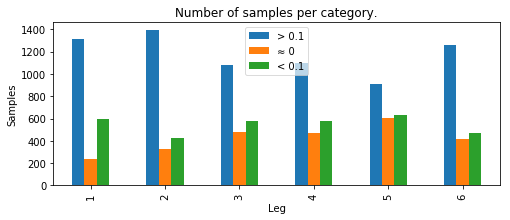

In [42]:
plus, zero, minus = get_categories(y)
count = get_count(plus, zero, minus)
count.plot.bar(figsize=(8, 3))
plt.legend(("> 0.1", "≈ 0", "< 0.1"), framealpha=0.7, loc=9)
plt.title("Number of samples per category.")
plt.xticks(range(6), range(1, 7))
plt.xlabel("Leg")
plt.ylabel("Samples")
plt.savefig("classification-samples-per-category.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [120]:
scaling = count.apply(lambda x: [1 / (xi / x[0]) for xi in x], axis=1)
scaling
# The necessary scaling factor

,plus,zero,minus
M2,1.0,5.567797,2.204698
M3,1.0,4.259939,3.269953
M4,1.0,2.246888,1.864028
M5,1.0,2.354701,1.913194
M6,1.0,1.507438,1.449921
M7,1.0,2.995238,2.688034


That is not very balanced. Better take zero and minus category times two.

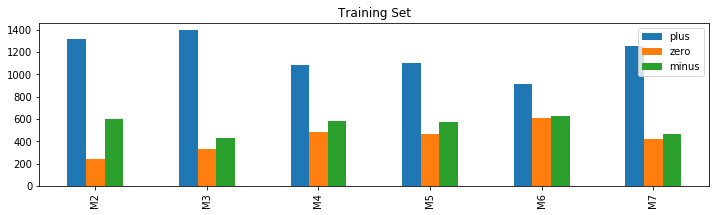

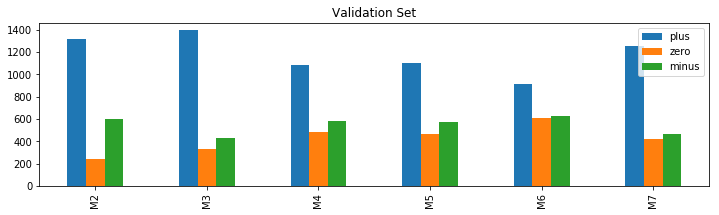

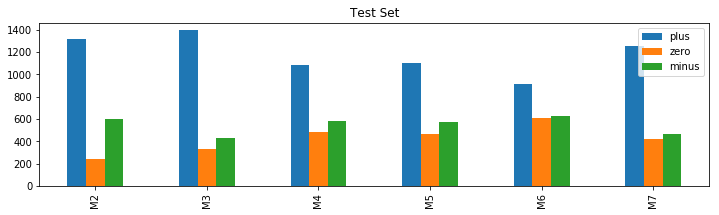

In [89]:
for dataset, name in zip(splitted_dataset(x, y), ("Training Set", "Validation Set", "Test Set")):
    cats = get_categories(y)
    cnt = get_count(*cats)
    cnt.plot.bar(figsize=(12, 3))
    plt.title(name)
plt.show()

Even the splitted data sets look similar. Seems there is no problem with doubling the underrepresented categories.

## Now for the mapping

$N \times M \to N \times M \times 3$

In [172]:
target = np.dstack((plus.values, zero.values, minus.values)).astype(float)
target.shape

(2146, 6, 3)

In [173]:
scaled_target = target * scaling.values
scaled_target.shape

(2146, 6, 3)

In [190]:
inputs = x.dropna().values
inputs = np.diff(inputs, axis=1)
inputs.shape

(2146, 7)

## Testwise training

Only for first leg

In [262]:
leg_nr = 0
(x_train, y_train), (x_val, y_val), (x_test, y_test) = splitted_dataset(
    pd.DataFrame(inputs), pd.DataFrame(target[:,leg_nr,:]))

In [276]:
input_layer = keras.layers.Input(shape=(7,), name="inputs")
hidden_layer = keras.layers.Dense(30, activation="relu", name="hidden")(input_layer)
output_layer = keras.layers.Dense(3, activation="softmax", name="predictions")(hidden_layer)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
print(model.summary())
model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train.values[:-1], y_train.values[1:], epochs=100, batch_size=32,
          validation_data=(x_val.values[:-1], y_val.values[1:]),
          class_weight={k:v for k, v in enumerate(scaling.iloc[leg_nr].values)})

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 7)                 0         
_________________________________________________________________
hidden (Dense)               (None, 30)                240       
_________________________________________________________________
predictions (Dense)          (None, 3)                 93        
Total params: 333
Trainable params: 333
Non-trainable params: 0
_________________________________________________________________
None
Train on 1505 samples, validate on 319 samples
Epoch 1/100
1505/1505 [==============================] - 0s - loss: 2.1602 - acc: 0.5362 - val_loss: 0.8369 - val_acc: 0.8401
Epoch 2/100
1505/1505 [==============================] - 0s - loss: 1.8694 - acc: 0.6877 - val_loss: 0.7239 - val_acc: 0.8589
Epoch 3/100
1505/1505 [==============================] - 0s - loss: 1.7584 - acc: 0.6565 - val_loss: 0.6

In [283]:
test_pred = model.predict(x_test.values[:-1])

In [278]:
def accuracy(y1, y2):
    return np.equal(np.argmax(y1, axis=-1), np.argmax(y2, axis=-1)).sum() / len(y1)

In [284]:
# Predicted accuracy
accuracy(test_pred, y_test.values[1:])

0.70846394984326022

In [285]:
# Naive accuracy
accuracy(y_test.values[:-1], y_test.values[1:])

0.80250783699059558

## Conclusion:

Classification works equally bad.

In [328]:
results_dict = {}

In [332]:
# Try for all the legs:
#days = 1
for days in range(1, 23, 3):
    network_predictions = []
    naive_predictions = []
    for leg_nr in range(6):
        (x_train, y_train), (x_val, y_val), (x_test, y_test) = splitted_dataset(
            pd.DataFrame(inputs), pd.DataFrame(target[:,leg_nr,:]))
        input_layer = keras.layers.Input(shape=(7,), name="inputs")
        hidden_layer = keras.layers.Dense(30, activation="relu", name="hidden")(input_layer)
        output_layer = keras.layers.Dense(3, activation="softmax", name="predictions")(hidden_layer)
        model = keras.models.Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer="Adam",
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(x_train.values[:-days], y_train.values[days:], epochs=100, batch_size=32,
                  validation_data=(x_val.values[:-days], y_val.values[days:]),
                  class_weight={k:v for k, v in enumerate(scaling.iloc[leg_nr].values)},
                  verbose=0)
        test_pred = model.predict(x_test.values[:-days])
        pred_acc = accuracy(test_pred, y_test.values[days:])
        naive_acc = accuracy(y_test.values[:-days], y_test.values[days:])
        network_predictions.append(pred_acc)
        naive_predictions.append(naive_acc)
    results = pd.DataFrame([pd.Series(naive_predictions), pd.Series(network_predictions)])
    results.columns = ["V" + str(i) for i in range(1, 7)]
    results.index = ["Naive", "Network"]
    results_dict[days] = results

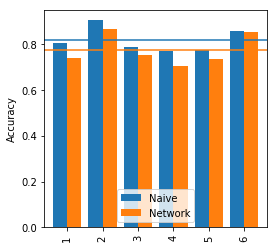

In [396]:
results_dict[1].T.plot.bar(figsize=(4, 4), width=0.8)
plt.legend(loc="lower center")
plt.axhline(results_dict[1].loc["Naive"].mean(), color="#1f77b4")
plt.axhline(results_dict[1].loc["Network"].mean(), color="#ff7f0e")
plt.ylabel("Accuracy")
plt.xticks(np.arange(6), list(range(1, 7)))
plt.savefig("classification-1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

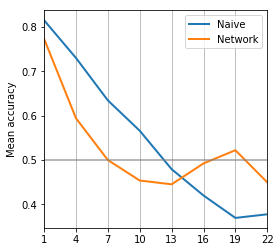

In [400]:
plt.figure(figsize=(4,4))
plt.plot(list(results_dict.keys()),
         [results_dict[i].loc["Naive"].mean() for i in results_dict],
         list(results_dict.keys()),
         [results_dict[i].loc["Network"].mean() for i in results_dict],
         linewidth=2)
plt.legend(("Naive", "Network"))
plt.ylabel("Mean accuracy")
plt.axhline(0.5, color="grey", alpha=0.75)
plt.xlim(1, 22)
plt.grid(axis="x")
plt.xticks(list(results_dict.keys()))
plt.savefig("classification-all.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()